In [1]:
import pandas as pd
from dataworks import DataWorks
dws = DataWorks()



In [80]:
def load_choice_file(path, field, name):
    """读取choice数据终端导出的数据文件.
        Choiced导出文件格式对应的处理规则. 
        - 原文件第一行为“宏观数据“或类似内容,但read_excel方法未加载该行内容
        - 数据的第一行作为指标标题
        - 第一列作为日期
        - 前六行和最后一行都不是数据内容
        - 剔除“日期”字段为空的行和其他非数据内容（标识数据来源的文字内容）
        
        Choice文件导出注意事项:
        - 导出字段选择:指标名称、频率、单位、来源
        - 日期排序:降序
        - 图形设置:不导出图形
        - 勾选“使用函数方式导出”
    Args:
        file_path (str): Choice导出文件(.xlsx)的绝对路径

    Returns:
        dataframe: 将Choice导出文件内容加载到dataframe,并返回
    """
    if path=='':
        return None
    df = pd.read_excel(path)
    df.columns = df.iloc[0]
    df.rename(columns={df.columns[0]: 'date'}, inplace=True)
    df = df.iloc[6:]
    if isinstance(field, list):
        df[name] = df[field[0]] + df[field[1]]
        df = df[['date', name]]
    else:
        df.rename(columns={field: name}, inplace=True)
        df = df[['date', name]]
        
    # df.reset_index(drop=True, inplace=True)
    # df.set_index('date', inplace=True)
    df.dropna(axis=0, subset=['date'], inplace=True)
    df = df[df['date'] != '数据来源：东方财富Choice数据']
    df['date'] = pd.to_datetime(df['date'])
    return df

In [81]:
config = dws.get_variety_setting('setting/variety.json')
variety_config = config['RB']
combined_df = None
for data_type, data_info in variety_config['DataIndex'].items():
    # 从文件中加载指定字段的数据
    data_df = load_choice_file(data_info['Path'], data_info['Field'], data_info['Name'])
    
    # 将数据添加到combined_df中
    # combined_df = pd.concat([combined_df, data_df], axis=1)
    combined_df = pd.merge(combined_df, data_df, on='date', how='outer') if combined_df is not None else data_df
# combined_df.dropna(axis=0, subset=['date'], inplace=True)

In [2]:
import pandas as pd
df_basis = dws.get_data_by_sql('SELECT * FROM basis')
df_basis = df_basis[['date', 'dom_basis']]

In [3]:
df_basis['date'] = pd.to_datetime(df_basis['date'])
ts = df_basis.set_index('date')['dom_basis']

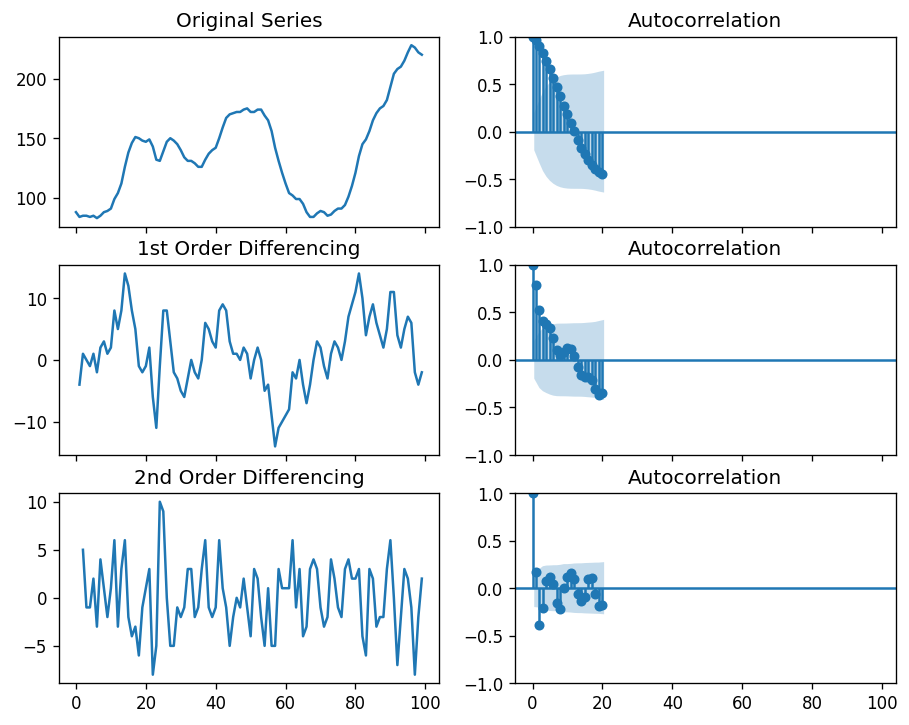

In [28]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data : Internet Usage per Minute
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


In [34]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Tue, 26 Mar 2024   AIC                            516.253
Time:                        23:15:51   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

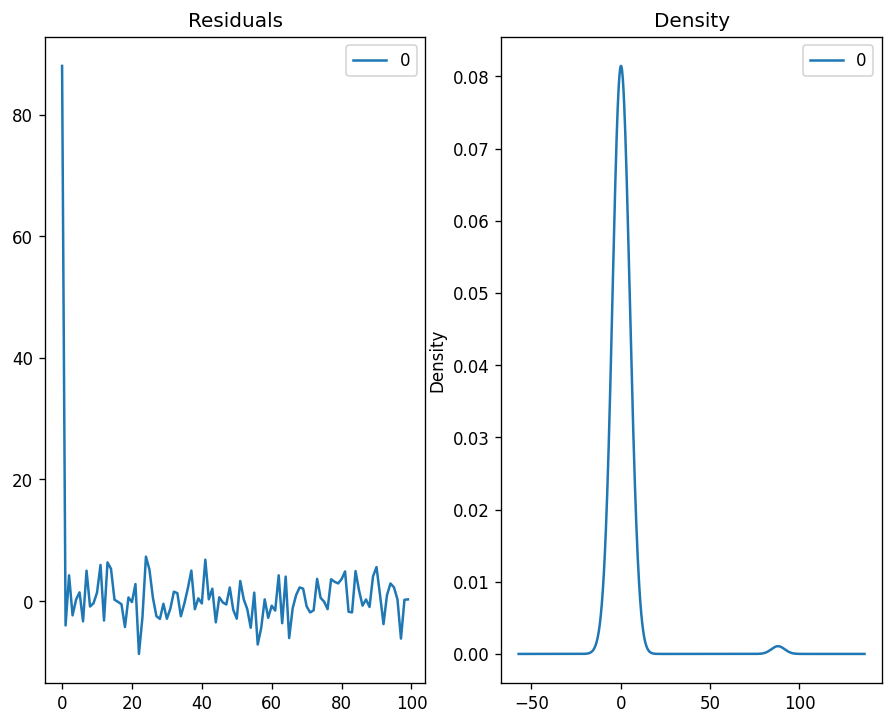

In [35]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [36]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()


AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'